# *Metabolic engineering of lactic acid bacteria,the combined approach : kinetic modelling,metabolic control and experimental analysis*

### By Hoefnagel MH et. al (2002)

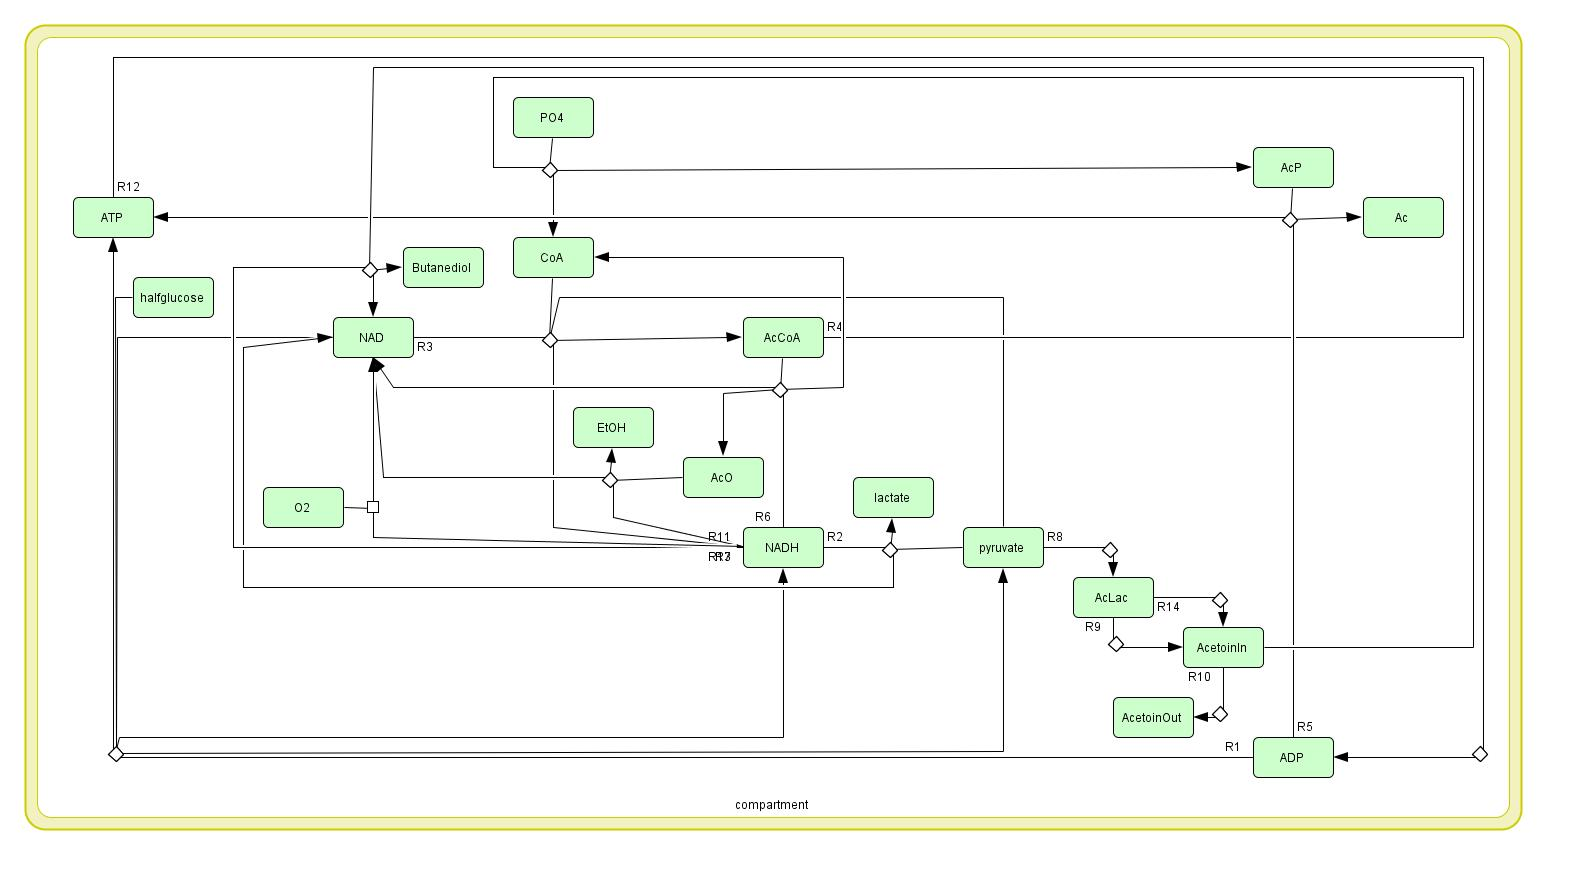

***

- $ R1 = \frac{4794 * (\frac{halfglucose}{0.2}) * \frac{NAD}{0.1412} * \frac{ADP}{0.046}}{(1 + \frac{halfglucose}{ 0.2} + \frac{pyruvate}{2.5}) * (1 + \frac{NAD}{0.1412} + \frac{NADH}{0.089}) * (1 + \frac{ADP}{0.046} + \frac{ATP}{0.018})} $
***
- $ R2  $



In [1]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
from pyomexmeta import RDF, eUriType
import os
import sys

# c) General
import copy
import difflib
import numpy as np
import pandas as pd
import math
import operator as op
import ast
import re

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams

# sbml
from libsbml import*
import simplesbml 

# Integration and fitting
from scipy.optimize import curve_fit, minimize, least_squares, newton_krylov, basinhopping
from scipy  import integrate
import scipy.stats as stats
# from symfit import parameters, variables, log, Fit, GreaterThan, Model
# from symfit.core.minimizers import BasinHopping
# from gekko import GEKKO



The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


In [25]:
# Figures settings

%config InlineBackend.figure_format = 'jpg'
import matplotlib as mpl
import matplotlib.ticker as ticker
mpl.rc('font',family='Times New Roman')
rcParams['figure.figsize'] = 6, 4

### Loading the *csv* file for the solutions, including *species* and *reaction rates*:

In [3]:
sboRef = pd.read_csv('SBO.csv')
sboID = sboRef['http://www.geneontology.org/formats/oboInOwl#id']
sboMeaning = sboRef['http://www.w3.org/2000/01/rdf-schema#label']
sboSynonyms = sboRef['Synonyms']

reader = SBMLReader()
document = reader.readSBML("BIOMD0000000017.xml")
document.getNumErrors()

model_lib = document.getModel()
model_simple = simplesbml.loadSBMLFile("BIOMD0000000017.xml")

solutions = pd.read_csv('solutions.csv')

print ('Num compartmetns = ', model_simple.getNumCompartments())
print ('Num parameters =', model_simple.getNumParameters())
print ('Num species =', model_simple.getNumSpecies())
print ('Num reactions = ', model_simple.getNumReactions())
print (model_simple.getListOfCompartmentIds())
print (model_simple.getListOfAllSpecies())
print ('List of reactions = ', model_simple.getListOfReactionIds())
print ('List of rules = ', model_simple.getListOfRuleIds())
print ('List of parameters = ', model_simple.getListOfParameterIds())


Num compartmetns =  2
Num parameters = 0
Num species = 19
Num reactions =  14
['compartment', 'extracellular']
['ADP', 'NAD', 'ATP', 'NADH', 'pyruvate', 'lactate', 'CoA', 'halfglucose', 'AcCoA', 'AcP', 'Ac', 'AcO', 'EtOH', 'AcLac', 'AcetoinIn', 'AcetoinOut', 'Butanediol', 'O2', 'PO4']
List of reactions =  ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14']
List of rules =  []
List of parameters =  []


In [4]:
reaction_reactants={}; reaction_products={}; reaction_modifiers={}; Synthesis=[]; Dtype=[]

for reaction in model_simple.getListOfReactionIds():
    reaction_reactants[reaction]=[]
    reaction_products[reaction]=[]
    
    reactNum=model_simple.getNumReactants(reaction)
    prodNum=model_simple.getNumProducts(reaction)
    modifierNum=model_simple.getNumModifiers(reaction)
    
    if reactNum is 0:
        Synthesis.append(reaction)
    if prodNum is 0:
        Dtype.append(reaction)
        

    for i in range(reactNum):
        reaction_reactants[reaction].append((model_simple.getReactantStoichiometry(reaction, i),model_simple.getReactant(reaction, i)))
        

    for ii in range(prodNum):
        reaction_products[reaction].append((model_simple.getProductStoichiometry(reaction, ii),model_simple.getProduct(reaction, ii)))

    if modifierNum is not 0:
        
        reaction_modifiers[reaction]=[]
        for iii in range(modifierNum):
            reaction_modifiers[reaction].append(model_simple.getListOfModifiers(reaction)[0])
            
            
reversibles=[]; irreversibles=[]; 
for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):
        
    if model_lib.getListOfReactions()[r].getReversible() is True:
        reversibles.append(reaction)
    elif reaction not in [synth for synth in Synthesis] and reaction not in [d for d in Dtype]:
        irreversibles.append(reaction)  

# Check if it's a simple irreversible reaction (v = product of the reactants)
ops = {
    '+' : op.add,
    '-' : op.sub,
    '*' : op.mul,
    '/' : op.truediv,  
    '^' : op.xor,
}
simpleIrreversible=[];  userDefinedIrreversible=[];
for reaction in irreversibles:
    rateLaw = model_simple.getRateLaw(reaction)
    operands = []
    for x in rateLaw.split(sep=" "):
        if x in ops:
            operands.append(x)
    if len(set(operands))==1 and set(operands) == {'*'}:
        simpleIrreversible.append(reaction)
    else:
        userDefinedIrreversible.append(reaction)
        
        
speciesId=[]
for species in model_simple.getListOfAllSpecies():
    for i,reacs in enumerate(reaction_reactants.values()):
        if species in [reac[1] for reac in reacs] and species not in [d for d in speciesId]:
            speciesId.append(species)

    for i,prods in enumerate(reaction_products.values()):
        if species in [prod[1] for prod in prods] and species not in [d for d in speciesId]:
            speciesId.append(species)

In [5]:
irreversibles

['R1',
 'R2',
 'R3',
 'R4',
 'R5',
 'R6',
 'R7',
 'R8',
 'R9',
 'R10',
 'R11',
 'R12',
 'R13',
 'R14']

In [6]:
reversibles

[]

In [7]:
reaction_reactants

{'R1': [(1.0, 'ADP'), (1.0, 'NAD'), (1.0, 'halfglucose')],
 'R2': [(1.0, 'NADH'), (1.0, 'pyruvate')],
 'R3': [(1.0, 'NAD'), (1.0, 'pyruvate'), (1.0, 'CoA')],
 'R4': [(1.0, 'AcCoA'), (1.0, 'PO4')],
 'R5': [(1.0, 'ADP'), (1.0, 'AcP')],
 'R6': [(1.0, 'NADH'), (1.0, 'AcCoA')],
 'R7': [(1.0, 'NADH'), (1.0, 'AcO')],
 'R8': [(2.0, 'pyruvate')],
 'R9': [(1.0, 'AcLac')],
 'R10': [(1.0, 'AcetoinIn')],
 'R11': [(1.0, 'NADH'), (1.0, 'AcetoinIn')],
 'R12': [(1.0, 'ATP')],
 'R13': [(1.0, 'NADH'), (1.0, 'O2')],
 'R14': [(1.0, 'AcLac')]}

In [8]:
reaction_products

{'R1': [(1.0, 'ATP'), (1.0, 'NADH'), (1.0, 'pyruvate')],
 'R2': [(1.0, 'NAD'), (1.0, 'lactate')],
 'R3': [(1.0, 'NADH'), (1.0, 'AcCoA')],
 'R4': [(1.0, 'CoA'), (1.0, 'AcP')],
 'R5': [(1.0, 'ATP'), (1.0, 'Ac')],
 'R6': [(1.0, 'NAD'), (1.0, 'CoA'), (1.0, 'AcO')],
 'R7': [(1.0, 'NAD'), (1.0, 'EtOH')],
 'R8': [(1.0, 'AcLac')],
 'R9': [(1.0, 'AcetoinIn')],
 'R10': [(1.0, 'AcetoinOut')],
 'R11': [(1.0, 'NAD'), (1.0, 'Butanediol')],
 'R12': [(1.0, 'ADP')],
 'R13': [(1.0, 'NAD')],
 'R14': [(1.0, 'AcetoinIn')]}

In [9]:
# Using the SS concentrations & setting the K for products ==> K_p/K_R : 0.001*(PSS/RSS),
# where PSS is the product of the steaqdy-state concentration of all the products and 
# RSS is the product of the steaqdy-state concentration of all the reactants in each reaction

kineticRatio = []
speciesXconstant = {}
for reaction in irreversibles:
    RSS = 1; PSS=1;
    for stoichiometry,reactant in reaction_reactants[reaction]:
        
        diff = solutions[reactant].diff() 
        diff.fillna(method='bfill', inplace=True)
        if diff.all() == 0 and solutions[reactant].all() == 0:
            RSS = RSS * 1
        else:
        
            length = solutions[reactant].size
            RSS = RSS * pow(solutions[reactant][length-1],stoichiometry)

    for stoichiometry,product in reaction_products[reaction]:
        
        diff = solutions[product].diff() 
        diff.fillna(method='bfill', inplace=True)
        if diff.all() == 0 and solutions[product].all() == 0:
            PSS = PSS * 1
        else:
            length = solutions[product].size
            PSS = PSS * pow(solutions[product][length-1],stoichiometry)
        
    kineticRatio.append(1e-3*RSS/PSS)
    
    
trueValues = copy.deepcopy(kineticRatio) 


rowM=[]
for s in speciesId:
     rowM.append(s)
for reaction in irreversibles:
    rowM.append(reaction+' X')

# M initial (regarding the steady-state ratios obtained in the previous stage)

M = np.zeros([len(trueValues),len(rowM)]) 


for i,reaction in zip(range(len(irreversibles)),irreversibles):

    for stoichiometry,reactant in reaction_reactants[irreversibles[i]]:
        for r in range(len(rowM)):     
            if rowM[r] == reactant:  
                M[i][r] = -stoichiometry


    for stoichiometry,product in reaction_products[irreversibles[i]]:
        for r in range(len(rowM)):     
            if rowM[r] == product:                    
                M[i][r] = stoichiometry
            
    for r in range(len(rowM)): 
        if rowM[r] == reaction+' X':
            M[i][r] = 1

logTrueValues = [];

for k in trueValues:
    logTrueValues.append(math.log(k))

logTrueValues = np.array(logTrueValues)


Mpinv = np.linalg.pinv(np.array(M))
logU = Mpinv.dot(logTrueValues)

thermodynamics = [math.exp(i) for i in list(logU)]

for i in range(len(thermodynamics)):
    print(rowM[i],' ==> ',thermodynamics[i])

for reaction in irreversibles:
    for i in range(len(rowM)):
        if rowM[i] == reaction+' X':
            speciesXconstant[rowM[i]] = thermodynamics[i]
    
diff = logTrueValues-M.dot(logU)
np.exp(diff)



ADP  ==>  2.368263767833549
NAD  ==>  0.045838122615265015
ATP  ==>  0.4222502634977942
NADH  ==>  21.815902199863995
pyruvate  ==>  24.57946206847906
lactate  ==>  0.9062671861911463
CoA  ==>  2.1033728909676257
halfglucose  ==>  49.8249701915938
AcCoA  ==>  0.4754268747563648
AcP  ==>  5.860681089106049
Ac  ==>  0.01907742766967657
AcO  ==>  2.6084494629789288
EtOH  ==>  0.021829762259683146
AcLac  ==>  333.12439256859136
AcetoinIn  ==>  12.381699811464964
AcetoinOut  ==>  0.00215519001468964
Butanediol  ==>  0.06137596835565181
O2  ==>  24.829742242139968
PO4  ==>  8.944006262091436
R1 X  ==>  0.020070257867785237
R2 X  ==>  0.9062671861911437
R3 X  ==>  0.003026795405520285
R4 X  ==>  0.11180671957246185
R5 X  ==>  0.019077427669676596
R6 X  ==>  0.056941831643228184
R7 X  ==>  0.021829762259683146
R8 X  ==>  0.5455953100688877
R9 X  ==>  0.04046989680769246
R10 X  ==>  0.00215519001468964
R11 X  ==>  0.06137596835565181
R12 X  ==>  0.0009067818918872743
R13 X  ==>  0.0402742803468

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


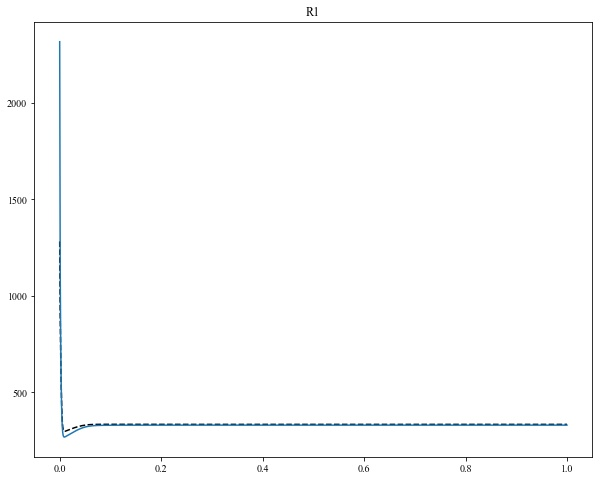

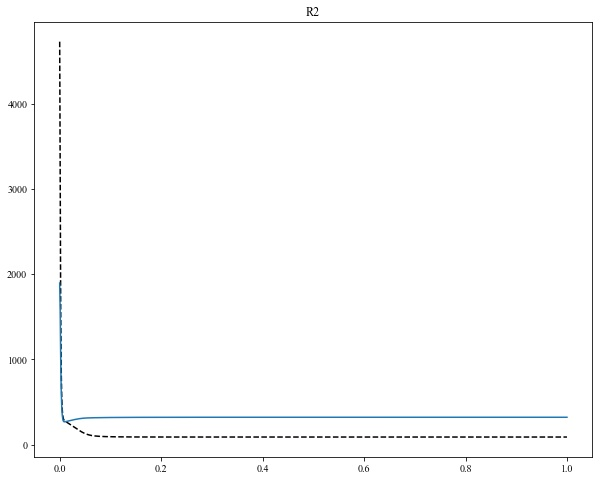

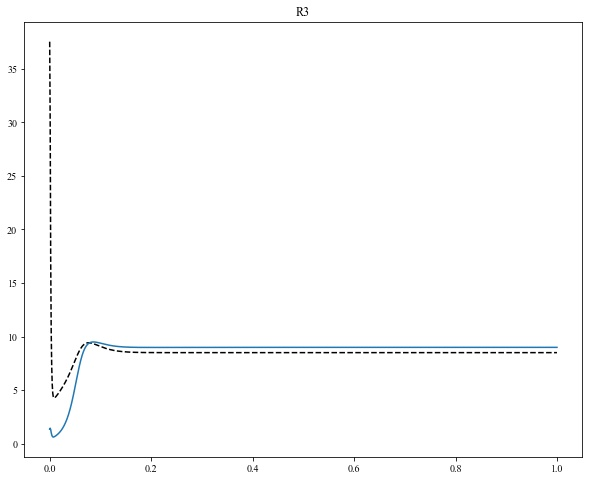

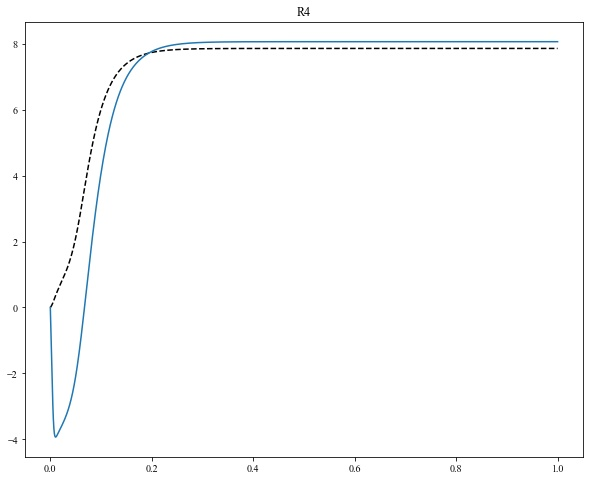

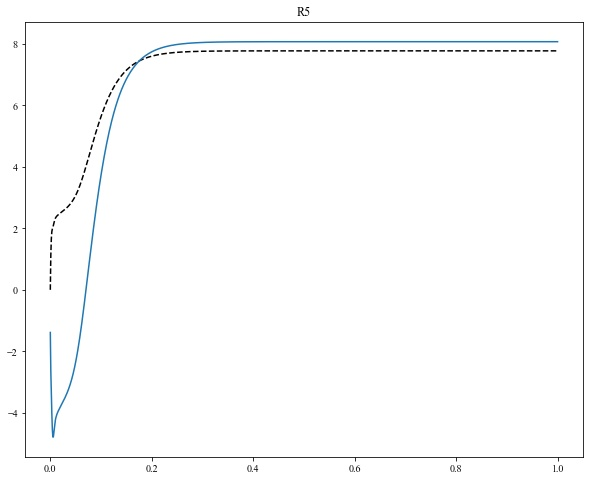

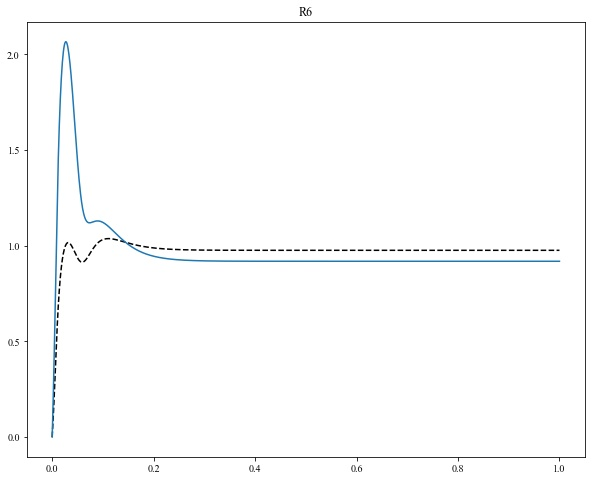

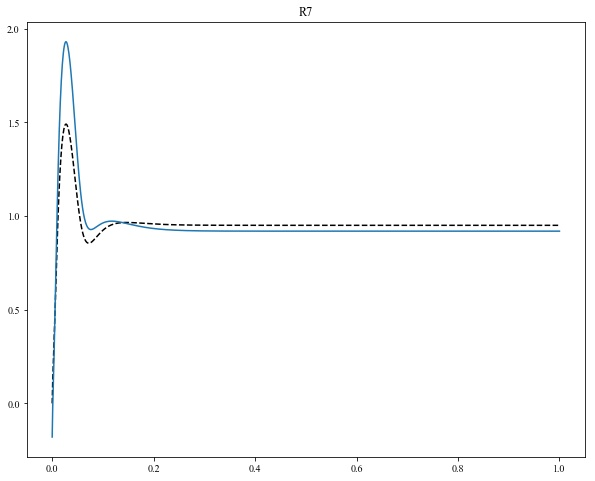

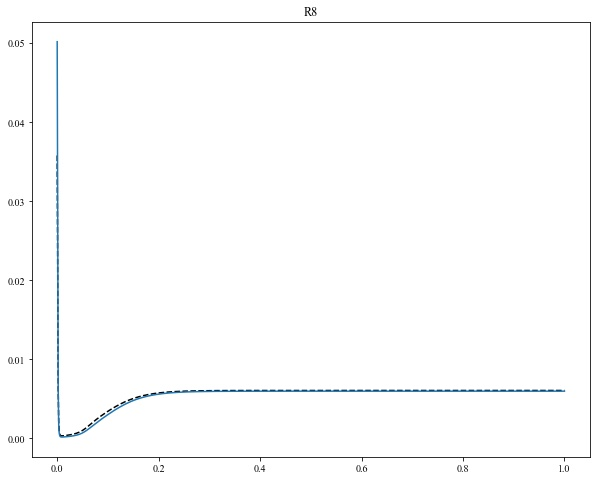

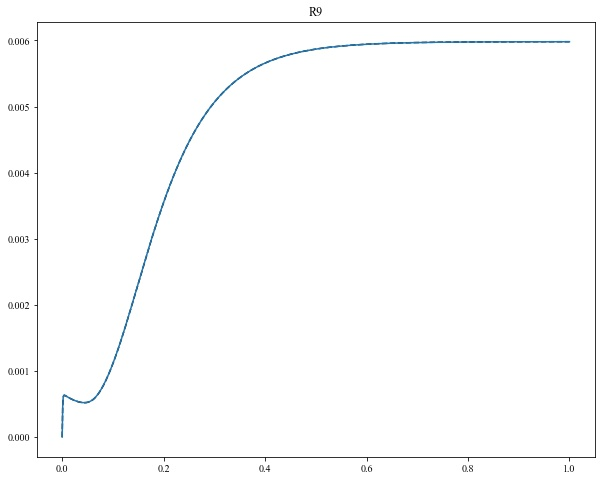

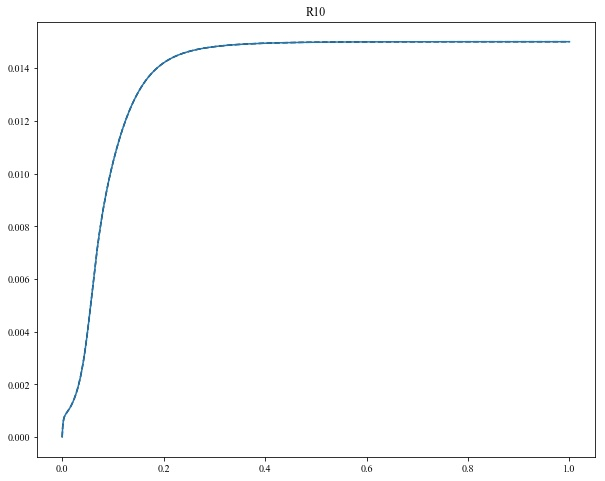

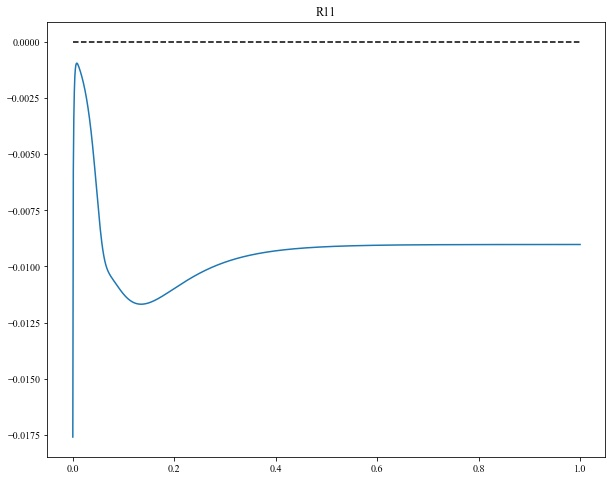

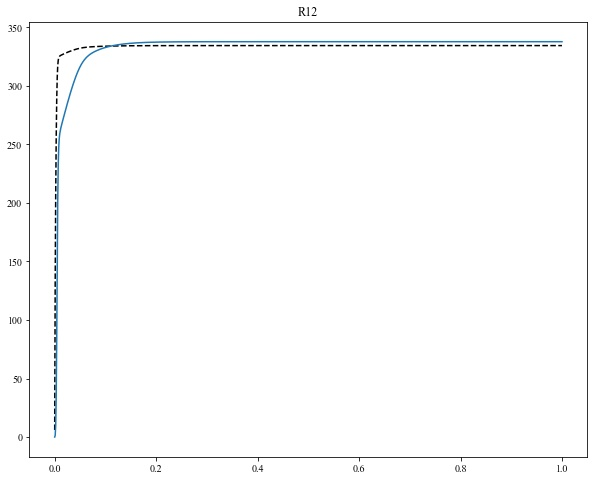

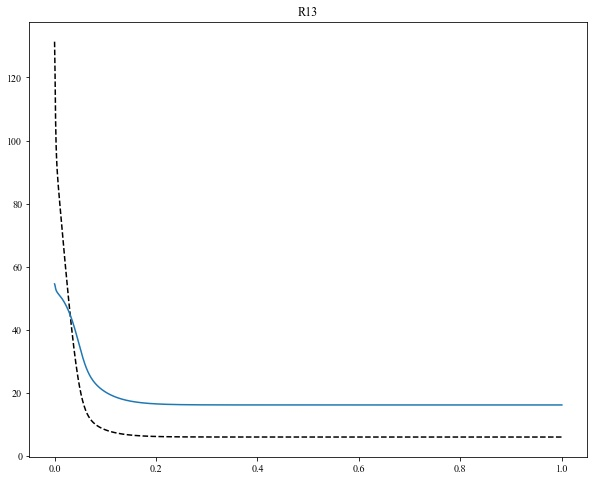

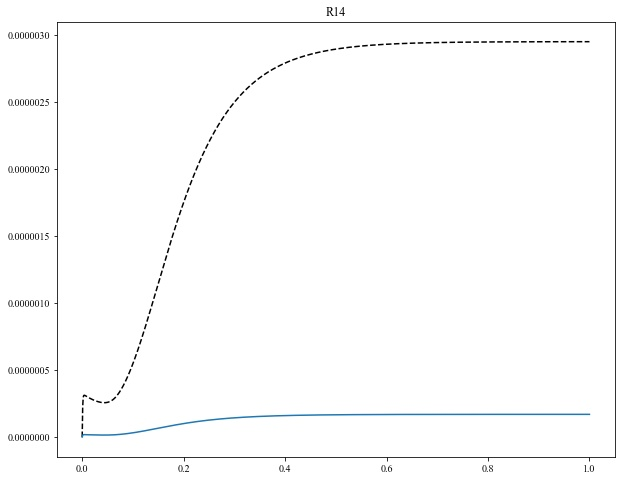

In [10]:
reactionRates = {}
for reaction in  irreversibles:
    
    reactantsSpecies=[]
    productsSpecies=[]
    modifierSpecies=[]
    
    K_reactants = 1
    K_products = 1
    K_modifier = 1
    
    solve=tuple()
    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(solutions[reactant],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(reactant) and set(rowM[i]) == set(reactant):
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   

    for stoichiometry,product in reaction_products[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(solutions[product],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(product) and set(rowM[i]) == set(product):
                K_products = K_products * pow(thermodynamics[i],stoichiometry)
            
    K_x = speciesXconstant[reaction+' X']
            
      
    def func(X, r):


        reactants = np.ones((len(solutions['Time'])))
        products= np.ones((len(solutions['Time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]
            

        v = r*(K_reactants*reactants- K_products*products*K_x)


        return v
 
    
    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,solutions[reaction], maxfev=300000, bounds=bounds)
    if popt[0]==1: 
        popt, pcov = curve_fit(func,solve,solutions[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]

    
    
    reactants = np.ones((len(solutions['Time'])))
    products = np.ones((len(solutions['Time'])))
    for s,reac in reaction_reactants[reaction]:
        reactants=reactants*pow(solutions[reac],s)
    for s,pro in reaction_products[reaction]:
        products=products*pow(solutions[pro],s)
        
    plt.figure()
    plt.plot(solutions['Time'],popt[0]*(K_reactants*reactants-K_products*products*K_x),'k--')
    plt.plot(solutions['Time'],solutions[reaction])
    plt.title(reaction)

In [11]:
# BG model 
BGmodel=bgt.new(name='BGmodel')
idealGassConstant=8.314
T= 310

BGspecies=[]; BGzeroJunc=[]; BGreactions=[]; oneJunc_reac=[]; oneJunc_prod=[]; TF=[];

    
for reaction in reversibles + irreversibles:
        
    BGreactions.append(bgt.new("Re", name=reaction, library="BioChem", value={'R':idealGassConstant, 'T':T}))

    oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction)) 
    oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction))

    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        if stoichiometry != 1:
            TF.append(bgt.new('TF', name='oneReac '+reaction+' '+reactant, value=stoichiometry))
            
    for stoichiometry,product in reaction_products[reaction]:
        if stoichiometry != 1:
            TF.append(bgt.new('TF', name='oneProd '+reaction+' '+product, value=1/stoichiometry))
            
    if reaction in irreversibles:
        BGspecies.append(bgt.new("Ce_S", name=reaction+' X', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=reaction+' X'))  
            
#     for forwardStoichiometry,backwardStoichiometry in refinedStoichiometries[reaction]:
#         TF.append(bgt.new('TF', name='oneReac '+reaction, value=forwardStoichiometry))
#         TF.append(bgt.new('TF', name='oneProd '+reaction, value=1/backwardStoichiometry))
        

    
for species in speciesId:
    diff = solutions[species].diff() 
    diff.fillna(method='bfill', inplace=True)
    if diff.all() != 0:
        BGspecies.append(bgt.new("Ce", name=species, library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=species)) 
    elif diff.all() == 0:
        BGspecies.append(bgt.new("Ce_S", name=species, library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=species)) 
    
    
for comp in TF:
    bgt.add(BGmodel,comp)
    
for comp1,comp2 in zip(BGspecies,BGzeroJunc):
    bgt.add(BGmodel,comp1,comp2)
    
for comp1,comp2,comp3 in zip(BGreactions,oneJunc_reac,oneJunc_prod):
    bgt.add(BGmodel,comp1,comp2,comp3)

In [12]:
# connections
connections = []

for z in BGzeroJunc:
    for s in BGspecies:
        if (z.name) == (s.name):
            connections.append((z,s))
    

for r in BGreactions:
    for oneR,oneP in zip(oneJunc_reac,oneJunc_prod):    
        if len('oneReac '+r.name) == len(oneR.name) and ('oneReac '+r.name) == (oneR.name):
            connections.append((oneR,r))
            
            
        if len('oneProd '+r.name) == len(oneP.name) and ('oneProd '+r.name) == (oneP.name):
            connections.append((r,oneP))

                
                
for reaction in reversibles + irreversibles:
    for oneR in oneJunc_reac:
        for xR in oneR.name.split(sep=" "):
            if (reaction) == (xR):

                for z in BGzeroJunc:
                    for stoichiometry,reactant in reaction_reactants[reaction]:
                        if  z.name == reactant:                            
                            if stoichiometry!=1:
                                for TFcomp in TF:
                                    if len(TFcomp.name) == len('oneReac '+reaction+' '+z.name) and set(TFcomp.name) == set('oneReac '+reaction+' '+z.name):
                                        connections.append((z,(TFcomp,0)))
                                        connections.append(((TFcomp,1),oneR))
                            else:
                                connections.append((z,oneR))

                                    
    for oneP in oneJunc_prod:
        for xP in oneP.name.split(sep=" "):
            if (reaction) == (xP):

                for z in BGzeroJunc:
                    for stoichiometry,product in reaction_products[reaction]:
                        if z.name == product:
                            if stoichiometry!=1:
                                for TFcomp in TF:
                                    if len(TFcomp.name) == len('oneProd '+reaction+' '+z.name) and set(TFcomp.name) == set('oneProd '+reaction+' '+z.name):
                                        connections.append((oneP,(TFcomp,0)))
                                        connections.append(((TFcomp,1),z))
                            else:
                                connections.append((oneP,z))
                            
                    if reaction in irreversibles:
                        if  z.name == reaction+' X':
                            connections.append((oneP,z))
    
      
        
for tail,head in connections:
    bgt.connect(tail,head)

In [13]:
# Setting the values in BGs
           
for BGreaction in BGreactions:
    if BGreaction.name in [key for key in reactionRates]:
            bgt.set_param(BGreaction,'r',reactionRates[BGreaction.name])
        

for bg in BGspecies:                   
    for i in range(len(rowM)):
        if bg.name == rowM[i]:
            bgt.set_param(bg,'k',thermodynamics[i])

            
for reaction in irreversibles:
    for bg in BGspecies: 
        if bg.name == reaction+' X':
            bgt.set_param(bg,'k',speciesXconstant[reaction+' X'])

In [14]:
# check if all the components have gotton the correct values
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'C':
        print(BGmodel.components[i],BGmodel.components[i]._params['k'])
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'R':
        print(BGmodel.components[i],BGmodel.components[i]._params['r'])
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'TF':
        print(BGmodel.components[i],BGmodel.components[i]._params['r'])
        

C: R1 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.020070257867785237}
C: R2 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.9062671861911437}
C: R3 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.003026795405520285}
C: R4 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.11180671957246185}
C: R5 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.019077427669676596}
C: R6 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.056941831643228184}
C: R7 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.021829762259683146}
C: R8 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.5455953100688877}
C: R9 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.04046989680769246}
C: R10 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.00215519001468964}
C: R11 X {'description': 'Biochemical Constant; exp(mu_0

In [15]:
BGmodel.state_vars

{'x_0': (C: R1 X, 'q_0'),
 'x_1': (C: R2 X, 'q_0'),
 'x_2': (C: R3 X, 'q_0'),
 'x_3': (C: R4 X, 'q_0'),
 'x_4': (C: R5 X, 'q_0'),
 'x_5': (C: R6 X, 'q_0'),
 'x_6': (C: R7 X, 'q_0'),
 'x_7': (C: R8 X, 'q_0'),
 'x_8': (C: R9 X, 'q_0'),
 'x_9': (C: R10 X, 'q_0'),
 'x_10': (C: R11 X, 'q_0'),
 'x_11': (C: R12 X, 'q_0'),
 'x_12': (C: R13 X, 'q_0'),
 'x_13': (C: R14 X, 'q_0'),
 'x_14': (C: ADP, 'q_0'),
 'x_15': (C: NAD, 'q_0'),
 'x_16': (C: ATP, 'q_0'),
 'x_17': (C: NADH, 'q_0'),
 'x_18': (C: pyruvate, 'q_0'),
 'x_19': (C: lactate, 'q_0'),
 'x_20': (C: CoA, 'q_0'),
 'x_21': (C: halfglucose, 'q_0'),
 'x_22': (C: AcCoA, 'q_0'),
 'x_23': (C: AcP, 'q_0'),
 'x_24': (C: Ac, 'q_0'),
 'x_25': (C: AcO, 'q_0'),
 'x_26': (C: EtOH, 'q_0'),
 'x_27': (C: AcLac, 'q_0'),
 'x_28': (C: AcetoinIn, 'q_0'),
 'x_29': (C: AcetoinOut, 'q_0'),
 'x_30': (C: Butanediol, 'q_0'),
 'x_31': (C: O2, 'q_0'),
 'x_32': (C: PO4, 'q_0')}

In [16]:
x_0 = {}
for stateVar in BGmodel.state_vars:                   
    for reaction in irreversibles:
        if BGmodel.state_vars[stateVar][0].name == reaction+' X':
            x_0[stateVar] =  1
            
for stateVar in BGmodel.state_vars:                   
    for bg in BGspecies:
        if bg.name in solutions:
            if len(BGmodel.state_vars[stateVar][0].name) == len(bg.name) and set(BGmodel.state_vars[stateVar][0].name) == set(bg.name):
                x_0[stateVar] =  solutions[bg.name][0]

    
x_0      

{'x_0': 1,
 'x_1': 1,
 'x_2': 1,
 'x_3': 1,
 'x_4': 1,
 'x_5': 1,
 'x_6': 1,
 'x_7': 1,
 'x_8': 1,
 'x_9': 1,
 'x_10': 1,
 'x_11': 1,
 'x_12': 1,
 'x_13': 1,
 'x_14': 4.9,
 'x_15': 6.33,
 'x_16': 0.1,
 'x_17': 3.67,
 'x_18': 1.0,
 'x_19': 0.1,
 'x_20': 1.0,
 'x_21': 30.0,
 'x_22': 0.0,
 'x_23': 0.0,
 'x_24': 1.0,
 'x_25': 0.0,
 'x_26': 1.0,
 'x_27': 0.0,
 'x_28': 0.0,
 'x_29': 0.0,
 'x_30': 0.01,
 'x_31': 0.2,
 'x_32': 10.0}

In [17]:
t_span = [0,solutions['Time'][len(solutions['Time'])-1]]
t, x = bgt.simulate(BGmodel, timespan=t_span, control_vars={}, x0=x_0, dt=solutions['Time'][1]-solutions['Time'][0])

In [18]:
# Saving the simulations as a csv file
xDict = {}
for i in range(np.size(x,1)):
    xDict[i] = x[:,i]
    
bgData = pd.DataFrame(xDict)
bgData.to_csv("/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/halfgloucose to AcCOA/BIOMD0000000017/Comparison/bgData.csv",\
         sep=',', index=False) 

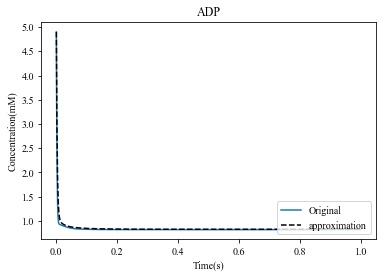

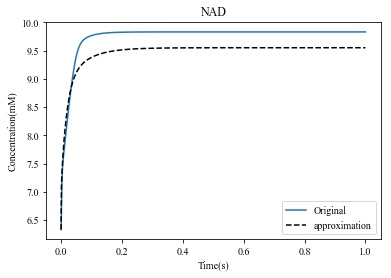

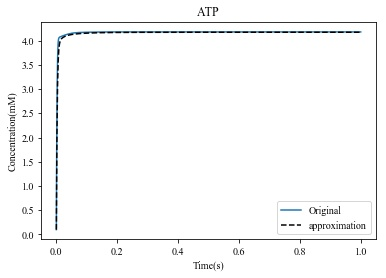

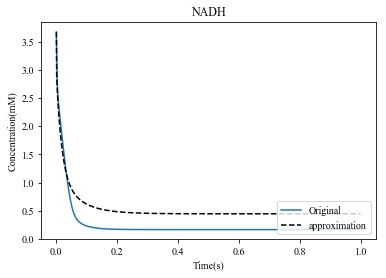

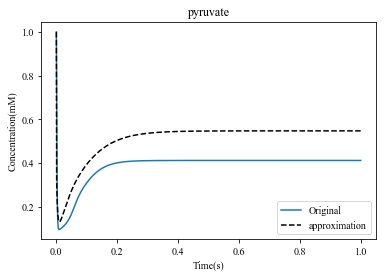

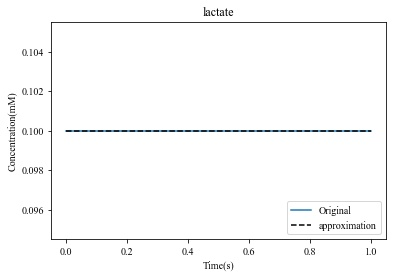

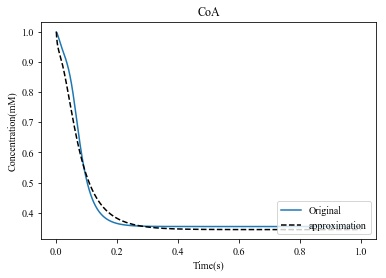

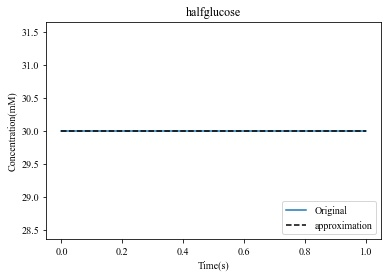

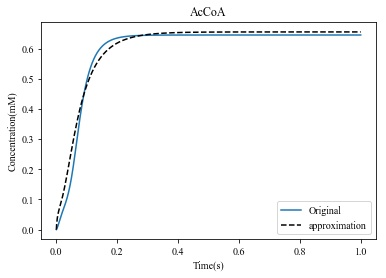

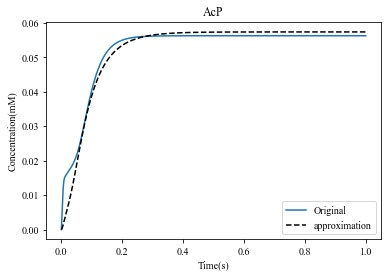

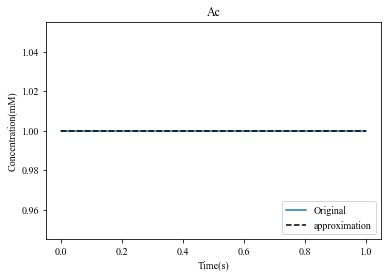

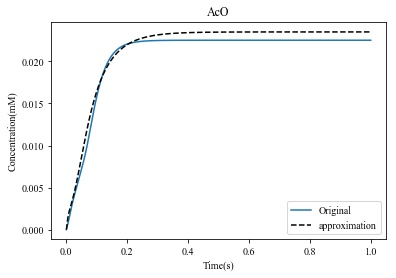

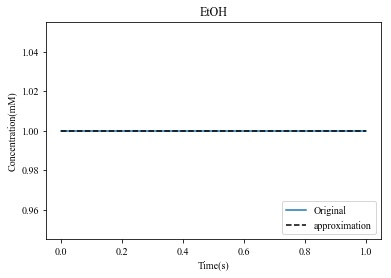

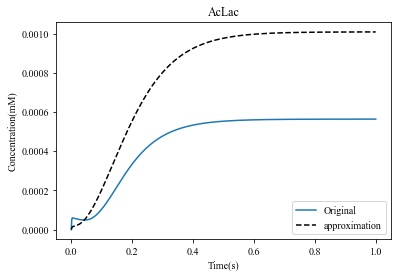

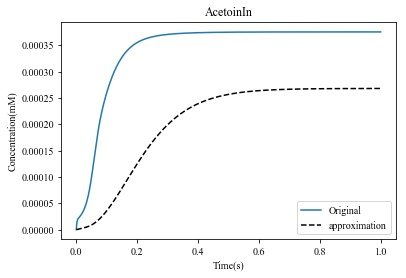

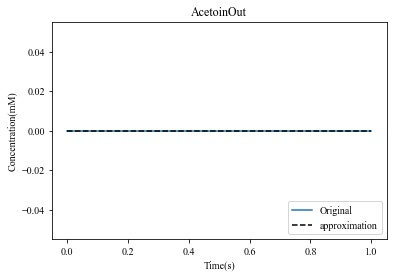

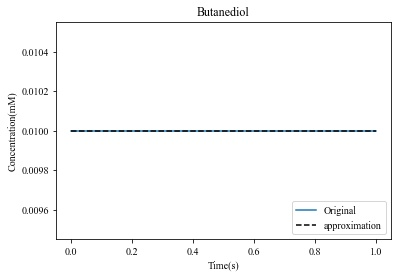

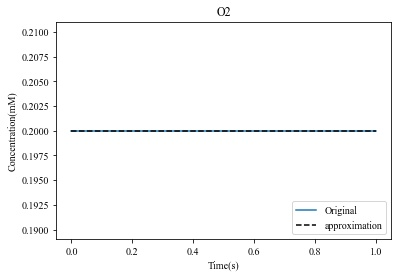

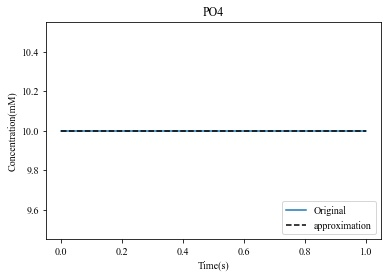

In [26]:
for stateVar,i in zip(BGmodel.state_vars,range(len(BGmodel.state_vars))):  
    if BGmodel.state_vars[stateVar][0].name in solutions:
        plt.figure()
        plt.title(BGmodel.state_vars[stateVar][0].name)
        plt.plot(solutions['Time'],solutions[BGmodel.state_vars[stateVar][0].name],label='Original')
        plt.plot(t,x[:,i],'--k',label='approximation')
        plt.legend(loc='lower right')
        plt.ylabel('Concentration(mM)')
        plt.xlabel('Time(s)')